In [1]:
import pandas as pd
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDRegressor, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from math import *
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#load the tsv files of the features and respective responses
df=pd.read_csv('MP_Data.tsv', sep='\t', index_col=False)
tt_df=df.rename(columns={'x':'test_train'})

In [3]:
x_df=pd.read_csv('MP_Descriptors.tsv', sep='\t', index_col=False)

In [4]:
y_df_init=pd.read_csv('MP_Outcome.tsv', sep='\t')
y_df=y_df_init.rename(columns={'x':'outcome'})

In [5]:
#sort the data according to test and train sets
x_train_df=x_df[tt_df['test_train']=='Train']
x_test_df=x_df[tt_df['test_train']=='Test']

y_train_df=y_df[tt_df['test_train']=='Train']
y_test_df=y_df[tt_df['test_train']=='Test']

In [6]:
x_train_df.shape, y_train_df.shape, x_test_df.shape, y_test_df.shape

((4126, 202), (4126, 1), (275, 202), (275, 1))

In [7]:
#normalize the observations
y_scaler=StandardScaler()
y_scaler.fit(y_train_df)
y_train_norm=y_scaler.transform(y_train_df)
y_test_norm=y_scaler.transform(y_test_df)

In [8]:
#minmax standardization
y_minmax=MinMaxScaler()
y_minmax.fit(y_train_df)
y_train_mm=y_minmax.transform(y_train_df)
y_test_mm=y_minmax.transform(y_test_df)

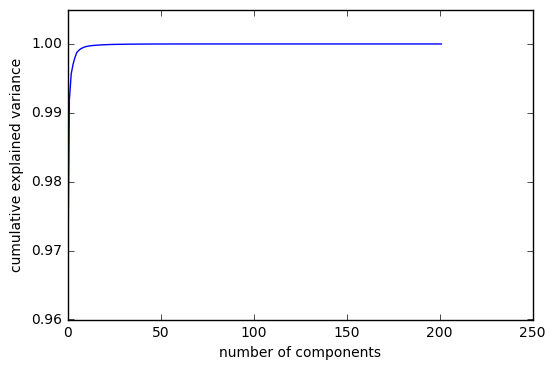

In [9]:
#feature selection
pca=PCA().fit(x_train_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [10]:
pca=PCA(n_components=30)#from the literature
x_train_pca=pca.fit_transform(x_train_df)
x_test_pca=pca.fit_transform(x_test_df)
x_train_pca.shape, x_test_pca.shape

((4126, 30), (275, 30))

In [11]:
#normalize the inputs#IS IT REQUIRED TO STANDARDIZE THE TEST DATA
x_scaler=StandardScaler()
x_scaler.fit(x_train_pca)
x_train_norm=x_scaler.transform(x_train_pca)
x_test_norm=x_scaler.transform(x_test_pca)
x_train_norm.shape, x_test_norm.shape

((4126, 30), (275, 30))

In [12]:
#minmax standardization
x_minmax=MinMaxScaler()
x_minmax.fit(x_train_pca)
x_train_mm=x_minmax.transform(x_train_pca)
x_test_mm=x_minmax.transform(x_test_pca)

In [13]:
#model building-linear regression using MINMAX STANDARDIZATION
regr=linear_model.LinearRegression()
regr.fit(x_train_mm, y_train_mm)
y_predict_mm=regr.predict(x_test_mm)
#normalize the y_predict
#y_predict_mm=y_minmax.fit_transform(y_predict)
#evaluate the model
#r2_linear_mm=r2_score(y_predict_mm, y_test_mm)
r2_linear_mm=r2_score(y_test_mm, y_predict_mm)
print('r2 for mm:',r2_linear_mm)
mse_linear_mm=mean_squared_error(y_test_mm, y_predict_mm)
print('mse for mm :',mse_linear_mm)
rmse_mm=sqrt(mse_linear_mm)
print('rmse for mm:', rmse_mm)
mae_mm=mean_absolute_error(y_test_mm, y_predict_mm)
print('mae for mm:', mae_mm)

r2 for mm: -0.447375178607
mse for mm : 0.0305887883781
rmse for mm: 0.17489650762108497
mae for mm: 0.140394286886


In [14]:
y_minmax.inverse_transform(y_predict_mm).shape

(275, 1)

In [15]:
#model building-linear regression WITH CROSS_VAL_SCORE 
regr=linear_model.LinearRegression()
regr.fit(x_train_mm, y_train_mm)
y_predict_mm=regr.predict(x_test_mm)
#normalize the y_predict
#y_predict_mm=y_minmax.fit_transform(y_predict)
#evaluate the model
kfold=KFold(n_splits=10, random_state=7, shuffle=True)
results=cross_val_score(regr, x_test_mm, y_predict_mm, cv=kfold, scoring='neg_mean_squared_error')
print('mse:', results.mean())

mse: -5.05160215297e-32


In [16]:
#model building-linear regression
regr=linear_model.LinearRegression()
regr.fit(x_train_norm, y_train_norm)
y_predict_norm=regr.predict(x_test_norm)
#normalize the y_predict
#y_predict_norm=y_scaler.fit_transform(y_predict)
#evaluate the model
#r2_linear=r2_score(y_predict_norm, y_test_norm)
r2_linear=r2_score(y_test_norm, y_predict_norm)
print('r2:',r2_linear)
mse_linear=mean_squared_error(y_test_norm, y_predict_norm)
print('mse :',mse_linear)
rmse=sqrt(mse_linear)
print('rmse:', rmse)
mae=mean_absolute_error(y_test_norm, y_predict_norm)
print('mae:', mae)

r2: -0.447375178607
mse : 1.04954447307
rmse: 1.0244727781005807
mae: 0.822372768169


In [17]:
y_predict_true=y_scaler.inverse_transform(y_predict_norm)
#mse in the true space
r2_linear=r2_score(y_test_df, y_predict_true)
print('r2 for linear in true space:', r2_linear)
mse_linear=mean_squared_error(y_test_df, y_predict_true)
print('mse for linear in true space:', mse_linear)
rmse_linear=sqrt(mse_linear)
print('rmse for linear in true space:', rmse_linear)
mae_linear=mean_absolute_error(y_test_df, y_predict_true)
print('mae for linear in true space:', mae_linear)

r2 for linear in true space: -0.447375178607
mse for linear in true space: 4382.21864781
rmse for linear in true space: 66.19832813458052
mae for linear in true space: 53.1392375863


In [18]:
np.var(y_predict_norm), np.var(x_train_norm), np.var(x_test_norm), np.var(y_train_norm), np.var(y_test_norm)

(0.22942153346457567,
 0.99999999999999933,
 0.62091086932037232,
 0.99999999999999956,
 0.7251364321996312)

In [19]:
regr.score(x_train_norm, y_train_norm)

0.36719921602902406

In [20]:
#Lasso
regr_lasso=linear_model.Lasso(alpha=0.2)
regr_lasso.fit(x_train_norm, y_train_norm)
y_predict_lasso=regr_lasso.predict(x_test_norm)
#scale back to true space
y_predict_lasso_true=y_scaler.inverse_transform(y_predict_lasso)
#evaluate
mse_lasso=mean_squared_error(y_test_df, y_predict_lasso_true)
rmse_lasso=sqrt(mse_lasso)
mae_lasso=mean_absolute_error(y_test_df, y_predict_lasso_true)
r2_lasso=r2_score(y_test_df, y_predict_lasso_true)
print('r2 for lasso:',r2_lasso)
print('rmse for lasso', rmse_lasso)
print('mae for lasso', mae_lasso)

r2 for lasso: -0.0862747910793
rmse for lasso 57.34906102135678
mae for lasso 46.1790537329


In [21]:
regr_lasso.score(x_train_norm, y_train_norm)

0.042529392939505861

In [22]:
#LassoCV
model_CV=LassoCV(cv=20).fit(x_train_norm, y_train_norm)
y_predict_CV = model_CV.predict(x_test_norm)
#scale back to true space
y_predict_CV_true=y_scaler.inverse_transform(y_predict_CV)
#evaluate
mse_lassoCV=mean_squared_error(y_test_df, y_predict_CV_true)
rmse_lassoCV=sqrt(mse_lassoCV)
r2_lassoCV=r2_score(y_test_df, y_predict_CV_true)
mae_lassoCV=mean_absolute_error(y_test_df, y_predict_CV_true)
print('r2 for lassoCV:',r2_lassoCV)
print('rmse for lassoCV',rmse_lassoCV )
print('mae for lassoCV', mae_lassoCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for lassoCV: -0.445881074094
rmse for lassoCV 66.16415152282032
mae for lassoCV 53.1100616871


In [23]:
#LassoLarsCV
model_larsCV=LassoLarsCV(cv=20).fit(x_train_norm, y_train_norm)
y_predict_larsCV=model_larsCV.predict(x_test_norm)
#scale back to true space
y_predict_larsCV_true=y_scaler.inverse_transform(y_predict_larsCV)
#evaluate
r2_larsCV=r2_score(y_test_df, y_predict_larsCV_true)
mse_larsCV=mean_squared_error(y_test_df, y_predict_larsCV_true)
rmse_larsCV=sqrt(mse_larsCV)
mae_larsCV=mean_absolute_error(y_test_df, y_predict_larsCV_true)
print('rmse for lassCV:', rmse_larsCV)
print('r2 for lasso larsCV:',r2_larsCV)
print('mae for larsCV:', mae_larsCV)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse for lassCV: 66.1983281345805
r2 for lasso larsCV: -0.447375178607
mae for larsCV: 53.1392375863


In [24]:
#Bayesian Ridge
regr_b=linear_model.BayesianRidge()
model_b=regr_b.fit(x_train_norm, y_train_norm)
y_predict_b=model_b.predict(x_test_norm)
#scale back to original space
y_predict_b_true=y_scaler.inverse_transform(y_predict_b)
#evaluate
mse_b=mean_squared_error(y_test_df, y_predict_b_true)
rmse_b=sqrt(mse_b)
mae_b=mean_absolute_error(y_test_df, y_predict_b_true)
r2_b=r2_score(y_test_df, y_predict_b_true)
print('r2 for bayesian in true space:',r2_b)
print('rmse for bayesian in true space:', rmse_b)
print('mae for bayesian in true space:', mae_b)

r2 for bayesian in true space: -0.438634383683
rmse for bayesian in true space: 65.9981373833629
mae for bayesian in true space: 52.9714189195


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
#stochastic gradient descent
regr_sgd=SGDRegressor(loss='squared_loss', penalty=None, alpha=0.001, epsilon=0.0001)
model_sgd=regr_sgd.fit(x_train_norm, y_train_norm)
y_predict_sgd=model_sgd.predict(x_test_norm)
#scale back to original space
y_predict_sgd_true=y_scaler.inverse_transform(y_predict_sgd)
#evaluate
mse_sgd=mean_squared_error(y_test_df, y_predict_sgd_true)
rmse_sgd=sqrt(mse_sgd)
mae_sgd=mean_absolute_error(y_test_df, y_predict_sgd_true)
r2_sgd=r2_score(y_test_df, y_predict_sgd_true)
print('r2 for sgd in true space:',r2_sgd)
print('rmse for sgd in true space:', rmse_sgd)
print('mae for sgd in true space:', mae_sgd)

r2 for sgd in true space: -0.436332063558
rmse for sgd in true space: 65.94530614174853
mae for sgd in true space: 52.9466099654


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
regr_sgd2=linear_model.SGDRegressor(loss='huber', penalty=None)
model_sgd2=regr_sgd2.fit(x_train_norm, y_train_norm)
y_predict_sgd2=model_sgd2.predict(x_test_norm)
#scale back to original space
y_predict_sgd2_true=y_scaler.inverse_transform(y_predict_sgd2)
#evaluate
mse_sgd2=mean_squared_error(y_test_df, y_predict_sgd2_true)
rmse_sgd2=sqrt(mse_sgd2)
mae_sgd2=mean_absolute_error(y_test_df, y_predict_sgd2_true)
r2_sgd2=r2_score(y_test_df, y_predict_sgd2_true)
print('r2 for sgd2 in true space:',r2_sgd2)
print('rmse for sgd2 in true space:', rmse_sgd2)
print('mae for sgd2 in true space:', mae_sgd2)

r2 for sgd2 in true space: -0.385510758668
rmse for sgd2 in true space: 64.76813806598496
mae for sgd2 in true space: 52.0917503512


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
regr_sgd3=linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='none', alpha=0.0001)
model_sgd3=regr_sgd3.fit(x_train_norm, y_train_norm)
y_predict_sgd3=model_sgd3.predict(x_test_norm)
#scale back to original space
y_predict_sgd3_true=y_scaler.inverse_transform(y_predict_sgd3)
#evaluate
mse_sgd3=mean_squared_error(y_test_df, y_predict_sgd3_true)
rmse_sgd3=sqrt(mse_sgd3)
mae_sgd3=mean_absolute_error(y_test_df, y_predict_sgd3_true)
r2_sgd3=r2_score(y_test_df, y_predict_sgd3_true)
print('r2 for sgd3 in true space:',r2_sgd3)
print('rmse for sgd3 in true space:', rmse_sgd3)
print('mae for sgd3 in true space:', mae_sgd3)

r2 for sgd3 in true space: -0.473699908531
rmse for sgd3 in true space: 66.7976200737096
mae for sgd3 in true space: 53.2482900085


C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
#using tree
regr_tree=tree.DecisionTreeRegressor()
model_tree=regr_tree.fit(x_train_norm, y_train_norm)
y_predict_tree=model_tree.predict(x_test_norm)
#scale back to original space
y_predict_tree_true=y_scaler.inverse_transform(y_predict_tree)
#evaluate
mse_tree=mean_squared_error(y_test_df, y_predict_tree_true)
rmse_tree=sqrt(mse_tree)
mae_tree=mean_absolute_error(y_test_df, y_predict_tree_true)
r2_tree=r2_score(y_test_df, y_predict_tree_true)
print('r2 for tree in true space:',r2_tree)
print('rmse for tree in true space:', rmse_tree)
print('mae for tree in true space:', mae_tree)

r2 for tree in true space: -1.39483037138
rmse for tree in true space: 85.15180134009232
mae for tree in true space: 69.8658181891


In [29]:
regr_ridge=linear_model.Ridge(alpha=0.75)
model_ridge=regr_ridge.fit(x_train_norm, y_train_norm)
y_predict_ridge=model_ridge.predict(x_test_norm)
#scale back to original space
y_predict_ridge_true=y_scaler.inverse_transform(y_predict_ridge)
#evaluate
mse_ridge=mean_squared_error(y_test_df, y_predict_ridge_true)
rmse_ridge=sqrt(mse_ridge)
mae_ridge=mean_absolute_error(y_test_df, y_predict_ridge_true)
r2_ridge=r2_score(y_test_df, y_predict_ridge_true)
print('r2 for ridge in true space:',r2_ridge)
print('rmse for ridge in true space:', rmse_ridge)
print('mae for ridge in true space:', mae_ridge)

r2 for ridge in true space: -0.447248586125
rmse for ridge in true space: 66.19543310293533
mae for ridge in true space: 53.1368208086


In [30]:
regr_kr=KernelRidge(alpha=1.0)
model_kr=regr_kr.fit(x_train_norm, y_train_norm)
y_predict_kr=model_kr.predict(x_test_norm)
#scale back to original space
y_predict_kr_true=y_scaler.inverse_transform(y_predict_kr)
#evaluate
mse_kr=mean_squared_error(y_test_df, y_predict_kr_true)
rmse_kr=sqrt(mse_kr)
mae_kr=mean_absolute_error(y_test_df, y_predict_kr_true)
r2_kr=r2_score(y_test_df, y_predict_kr_true)
print('r2 for kernel ridge in true space:',r2_kr)
print('rmse for kernel ridge in true space:', rmse_kr)
print('mae for kernel ridge in true space:', mae_kr)

r2 for kernel ridge in true space: -0.447206403499
rmse for kernel ridge in true space: 66.19446840427238
mae for kernel ridge in true space: 53.1360154112


In [31]:
#support vector machines
svr_rbf=SVR(kernel='rbf', C=1e3)
model_rbf=svr_rbf.fit(x_train_norm, y_train_norm)
y_predict_rbf=model_rbf.predict(x_test_norm)
#scale back to original space
y_predict_rbf_true=y_scaler.inverse_transform(y_predict_rbf)
#evaluate
mse_rbf=mean_squared_error(y_test_df, y_predict_rbf_true)
rmse_rbf=sqrt(mse_rbf)
mae_rbf=mean_absolute_error(y_test_df, y_predict_rbf_true)
r2_rbf=r2_score(y_test_df, y_predict_rbf_true)
print('r2 for svm.rbf in true space:',r2_rbf)
print('rmse for svm.rbf in true space:', rmse_rbf)
print('mae for svm.rbf in true space:', mae_rbf)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.rbf in true space: -2.99899561589
rmse for svm.rbf in true space: 110.03527293815259
mae for svm.rbf in true space: 87.0748887691


In [32]:
svr_sig=SVR(kernel='sigmoid', C=1e3)
model_sig=svr_sig.fit(x_train_norm, y_train_norm)
y_predict_sig=model_sig.predict(x_test_norm)
#scale back to original space
y_predict_sig_true=y_scaler.inverse_transform(y_predict_sig)
#evaluate
mse_sig=mean_squared_error(y_test_df, y_predict_sig_true)
rmse_sig=sqrt(mse_sig)
mae_sig=mean_absolute_error(y_test_df, y_predict_sig_true)
r2_sig=r2_score(y_test_df, y_predict_sig_true)
print('r2 for svm.sig in true space:',r2_sig)
print('rmse for svm.sig in true space:', rmse_sig)
print('mae for svm.sig in true space:', mae_sig)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.sig in true space: -6971469.14973
rmse for svm.sig in true space: 145284.28724323265
mae for svm.sig in true space: 106407.762572


In [33]:
svr_poly=SVR(kernel='poly', C=1e3)
model_poly=svr_poly.fit(x_train_norm, y_train_norm)
y_predict_poly=model_poly.predict(x_test_norm)
#scale back to original space
y_predict_poly_true=y_scaler.inverse_transform(y_predict_poly)
#evaluate
mse_poly=mean_squared_error(y_test_df, y_predict_poly_true)
rmse_poly=sqrt(mse_poly)
mae_poly=mean_absolute_error(y_test_df, y_predict_poly_true)
r2_poly=r2_score(y_test_df, y_predict_poly_true)
print('r2 for svm.poly in true space:',r2_poly)
print('rmse for svm.poly in true space:', rmse_poly)
print('mae for svm.poly in true space:', mae_poly)

C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 for svm.poly in true space: -30.7205371927
rmse for svm.poly in true space: 309.90367603388313
mae for svm.poly in true space: 188.846526566


In [45]:
C=np.array([rmse_linear, rmse_lasso, rmse_lassoCV, rmse_larsCV, rmse_b, rmse_sgd, rmse_sgd2, rmse_sgd3, rmse_tree, rmse_ridge, rmse_kr, rmse_rbf])
C

array([  66.19832813,   57.34906102,   66.16415152,   66.19832813,
         65.99813738,   65.94530614,   64.76813807,   66.79762007,
         85.15180134,   66.1954331 ,   66.1944684 ,  110.03527294])

In [46]:
D=np.array(np.arange(1, 13.0, 1))
D

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.])

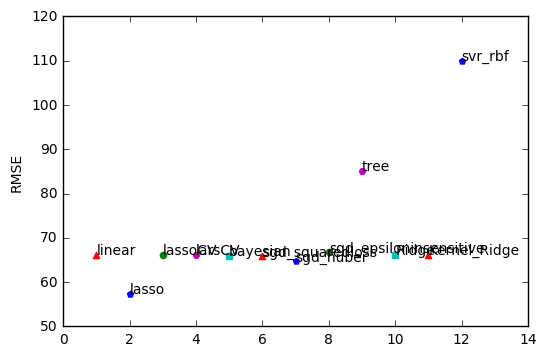

In [61]:
plt.scatter(D[0],C[0], color='r',marker='^', alpha=1)
plt.scatter(D[1],C[1], color='b',marker='p', alpha=1)
plt.scatter(D[2],C[2], color='g',marker='o', alpha=1)
plt.scatter(D[3],C[3], color='m',marker='H', alpha=1)
plt.scatter(D[4],C[4], color='c',marker='s', alpha=1)
plt.scatter(D[5],C[5], color='r',marker='^', alpha=1)
plt.scatter(D[6],C[6], color='b',marker='p', alpha=1)
plt.scatter(D[7],C[7], color='g',marker='o', alpha=1)
plt.scatter(D[8],C[8], color='m',marker='H', alpha=1)
plt.scatter(D[9],C[9], color='c',marker='s', alpha=1)
plt.scatter(D[10],C[10], color='r',marker='^', alpha=1)
plt.scatter(D[11],C[11], color='b',marker='p', alpha=1)
#plt.scatter(D[12],C[12], color='g',marker='o', alpha=1)
#plt.scatter(D[13],C[13], color='m',marker='H', alpha=1)
#plt.scatter(D[14],C[14], color='m',marker='H', alpha=1)
n=['linear','lasso','lassoCV','larsCV','bayesian','sgd_squaredloss','sgd_huber','sgd_epsiloninsensitive','tree','Ridge','Kernel_Ridge','svr_rbf']
for i, txt in enumerate(n):
    plt.annotate(txt, (D[i],C[i]))
plt.ylabel('RMSE')
plt.show()

**NEURAL NETWORK**

In [52]:
#DIFFERENT TOPOLOGIES HAVE BEEN GIVEN TO 2D , 3D AND 2D/3D DESCRIPTORS AND ITERATIONS OF CONJUGATED GRADIENT DESCENT GIVEN
def baseline_model():
    model=Sequential()
    model.add(Dropout(0.2, input_shape=(30,)))
    model.add(Dense(26, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(17, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, init='normal'))
    # compile the model 
    epochs=94
    learning_rate=0.01
    momemtum=0.3
    sgd=SGD(lr=learning_rate, momentum=momemtum, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [62]:
seed=7
#fit and evaluate the NN#USE OF STRATIFIEDKFOLD ONLY FOR BINARY CLASSIFICATION
estimators=[]
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)))
pipeline=Pipeline(estimators)
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
results=cross_val_score(pipeline, x_train_norm, y_train_norm, cv=kfold, scoring='mean_absolute_error')
abs(results.mean()*100), results.std()*100

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(26, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(17, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(26, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\li

(59.500981850033106, 2.7486076492378766)

In [63]:
results_test=cross_val_score(pipeline, x_test_norm, y_test_norm, cv=kfold, scoring='mean_absolute_error')
abs(results_test.mean()*100), results_test.std()*100

C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(26, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(17, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\saiva\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(26, activation="relu", kernel_initializer="normal")`
C:\Users\saiva\Miniconda3\li

(52.767273074791788, 7.9344124564557585)